# Demo for PyTorch Mask RCNN
Base Repo:  https://github.com/multimodallearning/pytorch-mask-rcnn

Sample Repo:  https://github.com/michhar/pytorch-mask-rcnn-samples

**Note:  Run this notebook inside of the Sample Repo after cloning**

## Installs and Setup

In [2]:
import torch
torch.__version__

'0.4.0'

In [3]:
import sys
sys.executable

'/user/miniconda3/envs/py35/bin/python'

In [4]:
! pip install h5py

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
! pip install scikit-image

    100% |################################| 25.3MB 30kB/s  eta 0:00:01
    100% |################################| 5.7MB 127kB/s eta 0:00:01
    100% |################################| 604kB 1.2MB/s eta 0:00:01
    100% |################################| 1.6MB 454kB/s eta 0:00:01
    100% |################################| 51kB 7.8MB/s eta 0:00:01
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /home/wonderwoman/.cache/pip/wheels/44/c0/34/6f98693a554301bdb405f8d65d95bbcd3e50180cbfdd98a94e
  Running setup.py bdist_wheel for toolz ... done
  Stored in directory: /home/wonderwoman/.cache/pip/wheels/f4/0c/f6/ce6b2d1aa459ee97cc3c0f82236302bd62d89c86c700219463
Successfully built networkx toolz
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


**Build two extensions**

* nms
* roi align

In [6]:
!  cd nms/src/cuda/ && nvcc -c -o nms_kernel.cu.o nms_kernel.cu -x cu -Xcompiler -fPIC &&\
cd ../../ &&\
python build.py

Including CUDA code.
/home/wonderwoman/work/pytorch-mask-rcnn-samples/nms
generating /tmp/tmpkkdt93bo/_nms.c
setting the current directory to '/tmp/tmpkkdt93bo'
running build_ext
building '_nms' extension
creating home
creating home/wonderwoman
creating home/wonderwoman/work
creating home/wonderwoman/work/pytorch-mask-rcnn-samples
creating home/wonderwoman/work/pytorch-mask-rcnn-samples/nms
creating home/wonderwoman/work/pytorch-mask-rcnn-samples/nms/src
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DWITH_CUDA -I/user/miniconda3/envs/py35/lib/python3.5/site-packages/torch/utils/ffi/../../lib/include -I/user/miniconda3/envs/py35/lib/python3.5/site-packages/torch/utils/ffi/../../lib/include/TH -I/user/miniconda3/envs/py35/lib/python3.5/site-packages/torch/utils/ffi/../../lib/include/THC -I/usr/local/cuda/include -I/user/miniconda3/envs/py35/include/python3.5m -c _nms.c -o ./_nms.o
gcc -pthread -Wno-unused-result -Wsign-compare -DN

In [7]:
!  cd roialign/roi_align/src/cuda/ &&\
nvcc -c -o crop_and_resize_kernel.cu.o crop_and_resize_kernel.cu -x cu -Xcompiler -fPIC -arch=sm_61 &&\
cd ../../ &&\
python build.py

Including CUDA code.
/home/wonderwoman/work/pytorch-mask-rcnn-samples/roialign/roi_align
generating /tmp/tmpdd7ld0_y/_crop_and_resize.c
setting the current directory to '/tmp/tmpdd7ld0_y'
running build_ext
building '_crop_and_resize' extension
creating home
creating home/wonderwoman
creating home/wonderwoman/work
creating home/wonderwoman/work/pytorch-mask-rcnn-samples
creating home/wonderwoman/work/pytorch-mask-rcnn-samples/roialign
creating home/wonderwoman/work/pytorch-mask-rcnn-samples/roialign/roi_align
creating home/wonderwoman/work/pytorch-mask-rcnn-samples/roialign/roi_align/src
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DWITH_CUDA -I/user/miniconda3/envs/py35/lib/python3.5/site-packages/torch/utils/ffi/../../lib/include -I/user/miniconda3/envs/py35/lib/python3.5/site-packages/torch/utils/ffi/../../lib/include/TH -I/user/miniconda3/envs/py35/lib/python3.5/site-packages/torch/utils/ffi/../../lib/include/THC -I/usr/loca

In [8]:
! ls

FixingPyTorchInstallManual.ipynb  coco.py		 model.py
LICENSE				  config.py		 nms
README.md			  demo.py		 roialign
Setup_and_Demo.ipynb		  fish_pytorch_style.py  utils.py
Train_Fish.ipynb		  images		 visualize.py


In [9]:
! cd roialign/roi_align/_ext/crop_and_resize/ && ls

__init__.py  _crop_and_resize.so


In [20]:
# ! wget http://images.cocodataset.org/zips/train2014.zip

--2018-04-25 14:29:36--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 172.217.5.112, 2607:f8b0:4005:808::2010
Connecting to images.cocodataset.org (images.cocodataset.org)|172.217.5.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: 'train2014.zip'

train2014.zip        51%[=========>          ]   6.54G  30.0MB/s    eta 4m 24s ^C


In [5]:
# ! python -m pip install docopt clint crontab tablib
# ! python -m pip install coco

    100% |################################| 71kB 3.0MB/s eta 0:00:01
    100% |################################| 696kB 1.0MB/s eta 0:00:01    57% |##################              | 399kB 23.9MB/s eta 0:00:01
    100% |################################| 174kB 3.6MB/s eta 0:00:01
    100% |################################| 112kB 3.7MB/s eta 0:00:01
    100% |################################| 102kB 2.8MB/s a 0:00:011
  Running setup.py bdist_wheel for docopt ... done
  Stored in directory: /home/wonderwoman/.cache/pip/wheels/9b/04/dd/7daf4150b6d9b12949298737de9431a324d4b797ffd63f526e
  Running setup.py bdist_wheel for clint ... done
  Stored in directory: /home/wonderwoman/.cache/pip/wheels/4f/e9/45/223565e5b1a4b09e12c6de6f8ba7c2c0e9127dec17cf830f83
  Running setup.py bdist_wheel for crontab ... done
  Stored in directory: /home/wonderwoman/.cache/pip/wheels/05/e9/56/636bc745f8683b8df5e9ec89bbfa5f87351c2d95503c60b221
  Running setup.py bdist_wheel for tablib ... done
  Stored in directory:

In [10]:
! python -m pip install Cython

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
! rm -fr cocoapi

In [12]:
! git clone https://github.com/cocodataset/cocoapi.git &&\
    cd cocoapi/PythonAPI &&\
    python setup.py build_ext --inplace

Cloning into 'cocoapi'...
remote: Counting objects: 936, done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 936 (delta 0), reused 4 (delta 0), pack-reused 931
Receiving objects: 100% (936/936), 11.69 MiB | 0 bytes/s, done.
Resolving deltas: 100% (557/557), done.
Checking connectivity... done.
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.5
creating build/temp.linux-x86_64-3.5/pycocotools
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/user/miniconda3/envs/py35/lib/python3.5/site-packages/numpy/core/include -I../common -I/user/miniconda3/envs/py35/include/python3.5m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.5/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC 

In [16]:
!  ln -s cocoapi/PythonAPI/pycocotools/ pycocotools

### Download the Model

Here:  https://drive.google.com/open?id=1VV6WgX_RNl6a9Yi9-Pe7ZyVKHRJZSKkm

And upload to the root directory of the repo on this machine (where this notebook lives).

## Setup and Run Inference

In [25]:
%load_ext autoreload
%autoreload
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import coco
# from pycocotools import coco
import utils
import model as modellib
import visualize

import torch


# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to trained weights file
# Download this file and place in the root of your
# project (See README file for details)
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.pth")

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    # GPU_COUNT = 0 for CPU
    GPU_COUNT = 0
    IMAGES_PER_GPU = 1
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.pth")


config = InferenceConfig()
config.display()

# Create model object.
model = modellib.MaskRCNN(model_dir=MODEL_DIR, config=config)
if config.GPU_COUNT:
    model = model.cuda()

# Load weights trained on MS-COCO
print(COCO_MODEL_PATH)
model.load_state_dict(torch.load(COCO_MODEL_PATH))

# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COCO_MODEL_PATH                /home/wonderwoman/work/pytorch-mask-rcnn-samples/mask_rcnn_coco.pth
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      0
IMAGENET_MODEL_PATH            /home/wonderwoman/work/pytorch-mask-rcnn-samples/resnet50_imagenet.pth
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX

/home/wonderwoman/work/pytorch-mask-rcnn-samples/model.py:1475: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


/home/wonderwoman/work/pytorch-mask-rcnn-samples/mask_rcnn_coco.pth


IndexError: too many indices for tensor of dimension 1

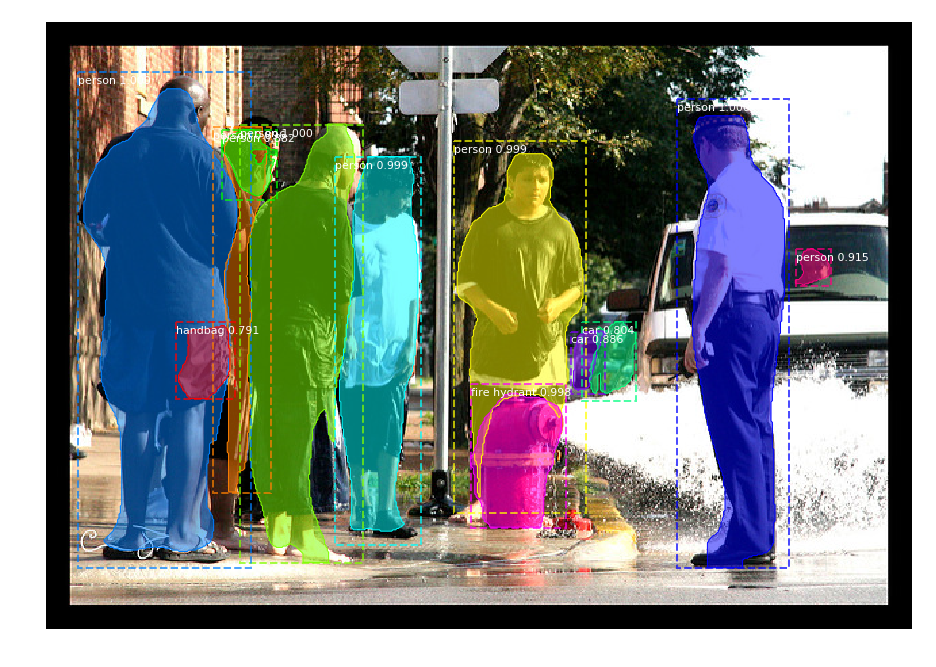

In [12]:
# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            class_names, r['scores'])
plt.show()

## Run an actual training experiment

In [14]:
! python coco.py train --dataset=mask_rcnn_coco.pth --model=imagenet

Command:  train
Model:  imagenet
Dataset:  mask_rcnn_coco.pth
Year:  2014
Logs:  /home/wonderwoman/pytorch-mask-rcnn/logs
Auto Download:  False

Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      0
IMAGENET_MODEL_PATH            /home/wonderwoman/pytorch-mask-rcnn/resnet50_imagenet.pth
IMAGES_PER_GPU                 16
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL            

In [ ]:
# Don't run unless trying to fix pytorch install and build from scratch as below

# import sys
# ! git clone https://github.com/pytorch/pytorch.git &&\
#     TORCH_CUDA_ARCH_LIST="3.7" {sys.executable} setup.py install